In [1]:
%matplotlib inline
import numpy as np
import sys
sys.path.append('./utils/')
from sklearn.utils.extmath import *
import adaptoctree.morton as morton
import adaptoctree.tree as tree
import fmm.surface as surface
from scripts.precompute_operators import rsvd
from fmm.kernel import laplace_gram_matrix_serial
import matplotlib.pyplot as plt
from functions_from_matlab import krylov_schur_svd

In [12]:
def compress_m2l_gram_matrix(
        dense_gram_matrix, level, x0, r0, depth, alpha_inner, check_surface,
        equivalent_surface, k, dtype
    ):
    """
    Compute compressed representation of unique Gram matrices for targets and
    sources at a given level of the octree, specified by their unique transfer
    vectors. Compression is computed using the randomised-SVD of Halko et. al.
    (2011).

    Parameters:
    -----------
    dense_gram_matrix: function
        Gram matrix function handle.
    level : int
        Octree level at which M2L operators are being calculated.
    x0 : np.array(shape=(1, 3), dtype=np.float64)
        Center of octree root node.
    r0 : np.float64
	    Half side length of octree root node.
    alpha_inner : float
        Relative size of inner surface.
    check_surface : np.array(shape=(ncheck_points, 3), dtype=float)
        Discretized check surface.
    equivalent_surface : np.array(shape=(nequivalent_points, 3), dtype=float)
        Discretized equivalent surface.
    k : int
        Target compression rank.

    Returns:
    --------
    (
        np.array(shape=(nu, k), float),
        np.array(shape=(ns), dtype=float),
        np.array(shape=(k, nvt), dtype=float),
        np.array(shape=(316), dtype=int)
    )
        Tuple of SVD components of aggregated M2L matrix at this level, as well
        as hashes of the transfer vectors to index the components by.
    """
    sources, targets, hashes = tree.find_unique_v_list_interactions(
        level=level, x0=x0, r0=r0, depth=depth
    )

    n_targets_per_node = len(check_surface)
    n_sources_per_node = len(equivalent_surface)
    n_sources = len(sources)

    # Create a collated equivalent to check surface for sources/targets
    # corresponding to unique transfer vectors at this level.
    se2tc = np.zeros((n_targets_per_node, n_sources*n_sources_per_node), dtype)

    for idx in range(len(targets)):

        target = targets[idx]
        source = sources[idx]

        target_center = morton.find_physical_center_from_key(
            key=target,
            x0=x0,
            r0=r0
        )

        source_center = morton.find_physical_center_from_key(
            key=source,
            x0=x0,
            r0=r0
        )

        lidx_sources = idx*n_sources_per_node
        ridx_sources = lidx_sources+n_sources_per_node

        target_check_surface = surface.scale_surface(
            surf=check_surface,
            radius=r0,
            level=level,
            center=target_center,
            alpha=alpha_inner
        )

        source_equivalent_surface = surface.scale_surface(
            surf=equivalent_surface,
            radius=r0,
            level=level,
            center=source_center,
            alpha=alpha_inner
        )

        se2tc[:, lidx_sources:ridx_sources] =  dense_gram_matrix(
                sources=source_equivalent_surface, targets=target_check_surface
            )

    return se2tc
    # Run RSVD compression.
    # u, s, vt = rsvd(se2tc, k)

    # return u, s, vt, hashes

In [13]:
order_equivalent = 2
order_check = 4
dtype = np.float32
equivalent_surface = surface.compute_surface(order_equivalent, dtype)
check_surface = surface.compute_surface(order_check, dtype)

In [14]:
equivalent_surface.shape

(8, 3)

In [15]:
check_surface.shape

(56, 3)

In [19]:
x0 = np.array([0., 0., 0.])
r0 = 0.5
alpha_inner = 1.05
alpha_outer = 1.95
k = 10
level = 2
depth = 3

In [20]:
se2tc = compress_m2l_gram_matrix(laplace_gram_matrix_serial, level, x0, r0, depth, alpha_inner, check_surface, equivalent_surface, k, dtype)

In [64]:
se2tc.shape

(56, 2528)

In [65]:
154208/316

488.0

# 1) SVD

In [66]:
u, s, vt = np.linalg.svd(se2tc.T)

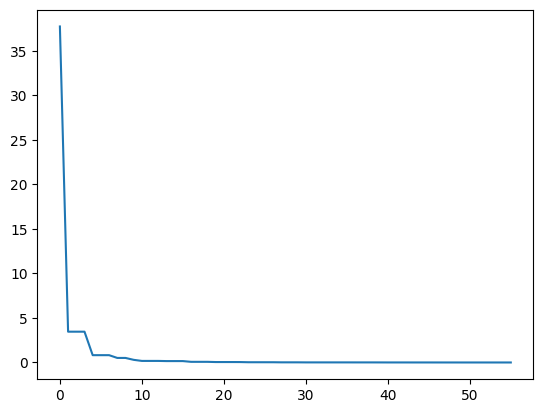

In [67]:
plt.plot(s)

In [68]:
s

array([ 37.7390,  3.4585,  3.4585,  3.4585,  0.8210,  0.8210,  0.8210,
        0.5104,  0.5104,  0.2970,  0.1751,  0.1751,  0.1751,  0.1565,
        0.1565,  0.1565,  0.0730,  0.0730,  0.0730,  0.0484,  0.0484,
        0.0484,  0.0459,  0.0272,  0.0272,  0.0265,  0.0265,  0.0160,
        0.0160,  0.0160,  0.0100,  0.0100,  0.0100,  0.0097,  0.0097,
        0.0097,  0.0085,  0.0085,  0.0085,  0.0066,  0.0041,  0.0041,
        0.0041,  0.0028,  0.0028,  0.0028,  0.0020,  0.0012,  0.0012,
        0.0006,  0.0006,  0.0006,  0.0002,  0.0002,  0.0002,  0.0001],
      dtype=float32)

# 2) Randomized SVD

In [21]:
u, s, vt = rsvd(se2tc.T, n_components = 7)

In [88]:
s

array([ 37.7390,  3.4585,  3.4585,  3.4585,  0.8210,  0.8210,  0.8210],
      dtype=float32)

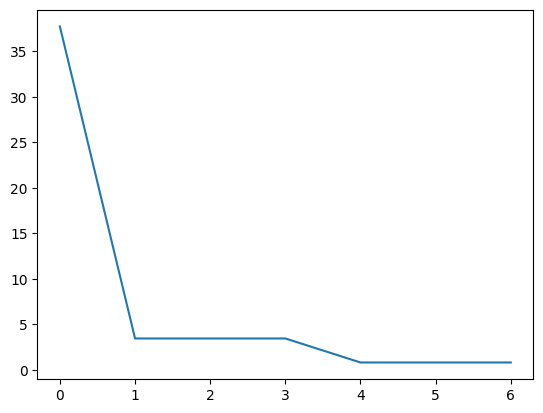

In [22]:
plt.plot(s)

# 3) Krylov Schur

In [71]:
se2tc.T

array([[ 0.1299,  0.1219,  0.1352, ...,  0.1288,  0.1454,  0.1649],
       [ 0.1423,  0.1411,  0.1630, ...,  0.1868,  0.2088,  0.2255],
       [ 0.0947,  0.0914,  0.1001, ...,  0.1049,  0.1133,  0.1219],
       ...,
       [ 0.0492,  0.0504,  0.0522, ...,  0.0589,  0.0575,  0.0559],
       [ 0.0492,  0.0509,  0.0522, ...,  0.0589,  0.0568,  0.0547],
       [ 0.0492,  0.0509,  0.0528, ...,  0.0613,  0.0589,  0.0565]],
      dtype=float32)

In [84]:
sigma, V, U, hist, mvs = krylov_schur_svd(se2tc.T)

[ 0.8045  0.9650  0.6352 ...  0.3822  0.3821  0.3820]
[ 0.4307  0.5211  0.3336 ...  0.1927  0.1930  0.1931]
[ 0.0399  0.0217  0.0021 ... -0.0308 -0.0298 -0.0300]
[-0.0117 -0.0362 -0.0059 ... -0.0022 -0.0028 -0.0030]
[-0.0084 -0.0026 -0.0002 ...  0.0001 -0.0008 -0.0004]
[ 0.0038  0.0102  0.0036 ...  0.0005  0.0000  0.0002]
[ 0.0078  0.0079  0.0028 ...  0.0003 -0.0002 -0.0003]
[ 0.0143 -0.0537  0.0069 ...  0.0010 -0.0036 -0.0073]
[-0.0018 -0.0044 -0.0002 ... -0.0000 -0.0001 -0.0002]
[ 0.0019  0.0012  0.0008 ... -0.0001 -0.0001 -0.0001]
Found after 0 iterations with residual = 0.00e+00


In [85]:
sigma

array([ 37.7390])

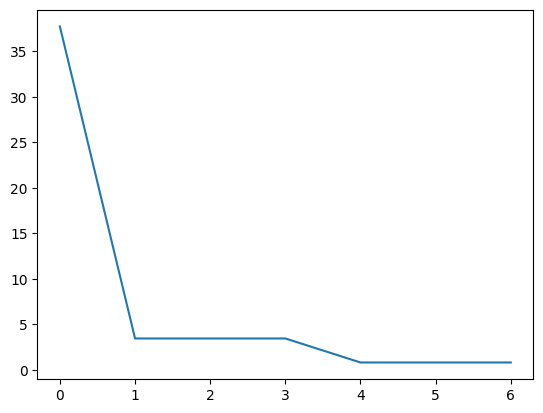

In [87]:
plt.plot(s)